# Formação Cientista de Dados - Data Science Academy
### Prevendo Customer Churn em Operadoras de Telecom
Projeto com Feedback 4

In [211]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Funções Utilitarias

In [212]:
# Carregar dados
def carrega_dados(nome_arquivo):
    return pd.read_csv(nome_arquivo)

In [213]:
# Gerar gráficos de balanceamento de classes
def plot_balanceamento_classes(classe, titulo):
    classes, counts = np.unique(classe, return_counts=True)
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel('Classes')
    plt.ylabel('Número de amostras')
    plt.title(titulo)
    
    for i in range(len(classes)):
        plt.text(x = classes[i] - 0.05, y = counts[i] + 1, s = counts[i])
    
    plt.show()

In [214]:
# Aplicar de label-encoding
def aplica_label_encoding(df, lista_colunas):
    le = LabelEncoder()
    for coluna in lista_colunas:
        df[coluna] = le.fit_transform(df[coluna])
    return df

In [215]:
# Selecionar melhores variaveis para o modelo
def selecionar_melhores_variaveis(x, y, quatidade_variaveis):
    logreg = LogisticRegression(max_iter=1200)
    rfe = RFE(estimator=logreg, n_features_to_select=quatidade_variaveis)
    rfe.fit(x, y)
    return x.columns[rfe.support_]

In [216]:
# Validar se possui/não possui informações
def validar_valores(valor):
    if valor > 0:
        return 1
    else:
        return 0

In [217]:
# Aplicar o SMOTE para balancear as classes
def aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(variavel_alvo, variaveis_preditoras)

In [218]:
# Gerar gráfico com a média de chamado em relação a clientes com churn ou não
def gerar_grafico_media_chamados_por_churn(df):
    categories = ['Não Churn', 'Churn']

    # Calcular a média de chamadas de serviço ao cliente para cada valor de churn
    churn_calls = df.groupby('churn')['number_customer_service_calls'].sum()

    # Definir as cores das barras
    colors = ['#1f77b4', '#ff7f0e']

    # Criar um gráfico de barras para mostrar as médias de chamadas de serviço ao cliente para cada valor de churn
    plt.bar(categories, churn_calls.values, color=colors)
    plt.title('Quantidade de chamadas de serviço ao cliente por churn')
    plt.xlabel('Cliente Churn')
    plt.ylabel('Quantidade de chamadas de serviço ao cliente')

    # Adicionar os valores das barras no gráfico
    for i, value in enumerate(churn_calls.values):
        plt.text(i, value, str(round(value, 2)), ha='center')

    plt.show()

In [219]:
def gerar_grafico_churn_por_area(df):
    # Criar uma tabela pivô com a contagem de "yes" e "no" por "area_code"
    df_pivot = df.pivot_table(index='area_code', columns='churn', values='state', aggfunc='count')

    # Transformar a tabela pivô em um DataFrame com as colunas "area_code", "churn" e "count"
    df_new = pd.DataFrame(df_pivot.to_records())
    df_new = df_new.rename(columns={'area_code': 'Area Code', 'no': 'Não churn', 'yes': 'Churn'})

    # Plotar um gráfico de barras com as colunas "yes" e "no" lado a lado
    ax = df_new.plot(x='Area Code', kind='bar', rot=0)

    # Adicionar rótulos de valores às barras
    for c in ax.containers:
        for r in c:
            h = r.get_height()
            ax.annotate(f'{h:.0f}', xy=(r.get_x() + r.get_width() / 2, h), 
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    # Adicionar rótulos de rótulos à base das barras
    ax.set_xlabel('Área')
    ax.set_ylabel('Quantidade de Churns')
    ax.set_title('Quantidade de Churns por Area')

    # Ajustar o tamanho do gráfico
    fig = ax.get_figure()
    fig.set_size_inches(8, 6)

    # Mostrar o gráfico
    plt.show()

Perguntas que podem ser feitas:

- Qual a porcentagem de churn por area_code?
- Qual o total pago pelo cliente?
- O total pago pelo cliente tem relação com o churn?
- 


### Análise exploratória de dados

In [220]:
# Carregando dados de Treino
df = carrega_dados("datasets/train.csv")

print('dimensões:', df.shape)
print('colunas:', df.columns)

# Analisando dataframe
df.head(5)

dimensões: (3333, 21)
colunas: Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [221]:
# Criando dicionario de dados
dic_dados = {
    'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
    'state': 'Estado dos EUA onde o cliente reside.',
    'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
    'area_code': 'Código de área do telefone do cliente.',
    'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
    'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
    'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
    'total_day_minutes': 'Total de minutos usados durante o dia.',
    'total_day_calls': 'Total de chamadas feitas durante o dia.',
    'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
    'total_eve_minutes': 'Total de minutos usados durante a noite.',
    'total_eve_calls': 'Total de chamadas feitas durante a noite.',
    'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
    'total_night_minutes': 'Total de minutos usados durante a noite.',
    'total_night_calls': 'Total de chamadas feitas durante a noite.',
    'total_night_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
    'total_intl_minutes': 'Total de minutos usados em chamadas internacionais.',
    'total_intl_calls': 'Total de chamadas feitas para números internacionais.',
    'total_intl_charge': 'Total cobrado pela operadora pelo uso de chamadas internacionais.',
    'number_customer_service_calls': 'Número de chamadas feitas pelo cliente ao serviço de atendimento ao cliente.',
    'churn': 'Indica se o cliente cancelou o contrato com a operadora (yes/no).'
}

# Convertendo lista de dicionários em DataFrame
#dicionario_dados = pd.DataFrame([{'variavel': k, 'descricao': v} for k, v in dic_dados.items()])
dic_dados

{'Unnamed: 0': 'Índice numérico das linhas do conjunto de dados.',
 'state': 'Estado dos EUA onde o cliente reside.',
 'account_length': 'Tempo que o cliente tem sido assinante da operadora.',
 'area_code': 'Código de área do telefone do cliente.',
 'international_plan': 'Indica se o cliente tem um plano internacional ativado (yes/no).',
 'voice_mail_plan': 'Indica se o cliente tem um plano de correio de voz ativado (yes/no).',
 'number_vmail_messages': 'Número de mensagens de correio de voz que o cliente tem.',
 'total_day_minutes': 'Total de minutos usados durante o dia.',
 'total_day_calls': 'Total de chamadas feitas durante o dia.',
 'total_day_charge': 'Total cobrado pela operadora pelo uso durante o dia.',
 'total_eve_minutes': 'Total de minutos usados durante a noite.',
 'total_eve_calls': 'Total de chamadas feitas durante a noite.',
 'total_eve_charge': 'Total cobrado pela operadora pelo uso durante a noite.',
 'total_night_minutes': 'Total de minutos usados durante a noite.',


In [222]:
# Selecionando coluna de indice
colunas_deletar = ['Unnamed: 0']

# Selecionando colunas com valores semelhantes
#colunas_deletar = colunas_deletar + ['area_code']
print('colunas que serão removidas:', colunas_deletar)

colunas que serão removidas: ['Unnamed: 0']


In [223]:
# Analisando dados que serão excluidos
df_colunas_deletar = df[colunas_deletar]
df_colunas_deletar.head(10)

,Unnamed: 0
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [224]:
# Removendo colunas
dados = df.drop(colunas_deletar, axis=1)

In [225]:
# Analisando dataframe após remover as colunas
print('dimensões:', dados.shape)
print('tipos das variáveis:\n', dados.dtypes)

dados.head(5)

dimensões: (3333, 20)
tipos das variáveis:
 state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [226]:
# Analisando coluna area_code
print('Valores únicos:', dados.area_code.unique())

# Aplicando regex para extrair somento o numero do texto
dados['area_code'] = dados.area_code.str.extract('(\d+)')

# Conferindo o resultado
print('Valores modificados:', dados.area_code.unique())

Valores únicos: ['area_code_415' 'area_code_408' 'area_code_510']
Valores modificados: ['415' '408' '510']


In [227]:
churn_por_area = dados.groupby('area_code')['churn'].value_counts()

maior_contagem = churn_por_area.max()
area_maior_contagem = churn_por_area[churn_por_area == maior_contagem].index.get_level_values(0)[0]

print("A área com o maior número de churns é a {}.".format(area_maior_contagem))

A área com o maior número de churns é a 415.


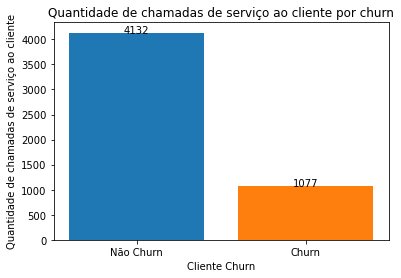

In [228]:
# Analisando a quantidade de chamados por clientes churn ou não
gerar_grafico_media_chamados_por_churn(dados)

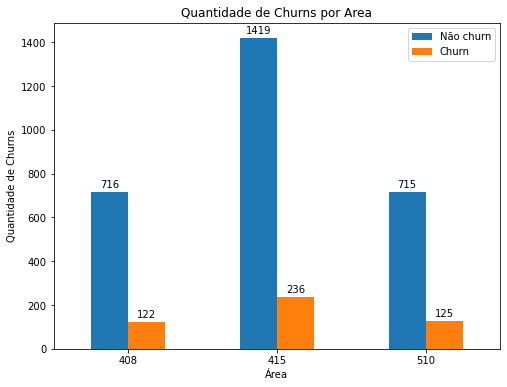

In [229]:
# Analisando quantidade de churn por área
gerar_grafico_churn_por_area(dados)

In [230]:
# Analisando área com maior número de cancelamentos
df_maior_valor_churn = dados.loc[(dados['area_code'] == str(area_maior_contagem)) & (dados['churn'] == 'yes')]
print('dimenssões:', df_maior_valor_churn.shape)
df_maior_valor_churn.head(5)

dimenssões: (236, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
10,IN,65,415,no,no,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,yes
15,NY,161,415,no,no,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,yes
48,ID,119,415,no,no,0,159.1,114,27.05,231.3,117,19.66,143.2,91,6.44,8.8,3,2.38,5,yes
54,WY,87,415,no,no,0,151.0,83,25.67,219.7,116,18.67,203.9,127,9.18,9.7,3,2.62,5,yes
76,DC,82,415,no,no,0,300.3,109,51.05,181.0,100,15.39,270.1,73,12.15,11.7,4,3.16,0,yes


In [231]:
# Verificar se precisa tratar outlier da variavel number_vmail_messages

# Analisando variáveis que podem ser modificadas por sim/não
print('valores de number_vmail_messages:', dados['number_vmail_messages'].unique())
print('valores de number_customer_service_calls:', dados['number_customer_service_calls'].unique())
dados.sample(5)

valores de number_vmail_messages: [25 26  0 24 37 27 33 39 30 41 28 34 46 29 35 21 32 42 36 22 23 43 31 38
 40 48 18 17 45 16 20 14 19 51 15 11 12 47  8 44 49  4 10 13 50  9]
valores de number_customer_service_calls: [1 0 2 3 4 5 7 9 6 8]


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
2059,KS,94,408,no,no,0,269.2,104,45.76,193.8,144,16.47,257.6,61,11.59,8.9,2,2.40,3,yes
3303,WI,114,415,no,yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,no
118,MO,112,510,no,yes,36,113.7,117,19.33,157.5,82,13.39,177.6,118,7.99,10.0,3,2.70,2,no
1370,PA,96,510,no,no,0,179.5,125,30.52,162.3,139,13.80,264.5,133,11.90,6.6,2,1.78,1,no
2959,NY,125,415,no,no,0,233.3,65,39.66,209.8,93,17.83,210.6,109,9.48,9.1,4,2.46,1,no


In [232]:
# Está tecnica aplicada apresentou piora na performance do modelo 
# Modificando colunas de valores numericos para binários
# df_modificado['number_vmail_messages'] = df_modificado['number_vmail_messages'].apply(validar_valores)
# df_modificado['number_customer_service_calls'] = df_modificado['number_customer_service_calls'].apply(validar_valores)
# df_modificado.sample(5)

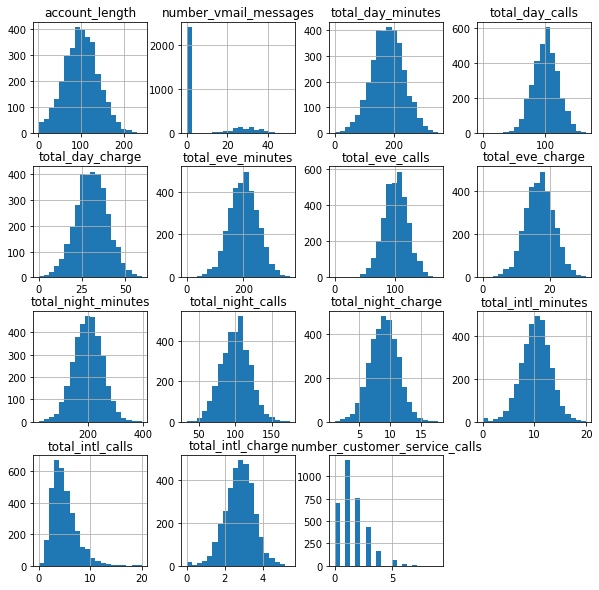

In [233]:
# Analisando distribuição dos dados
dados.hist(bins=20, figsize=(10,10))
plt.show()

### Tratamento dos dados

In [234]:
# Criando coluna total_charges para representar o total gasto pelo cliente
# continuar aqui

In [235]:
# Selecionando variáveis categóricas
variaveis_categoricas = dados.select_dtypes(include='object')

In [236]:
# Analisando valores únicos das variáveis categóricas
for v in variaveis_categoricas:
    print('valores únicos da variável', v, ':', list(dados[v].unique()))

print('\ncolunas modificadas:', list(variaveis_categoricas.columns))

valores únicos da variável state : ['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI', 'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC', 'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR', 'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC', 'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND']
valores únicos da variável area_code : ['415', '408', '510']
valores únicos da variável international_plan : ['no', 'yes']
valores únicos da variável voice_mail_plan : ['yes', 'no']
valores únicos da variável churn : ['no', 'yes']

colunas modificadas: ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


In [237]:
# Aplicando label-encoding nas variáveis categóricas
dados = aplica_label_encoding(dados, variaveis_categoricas.columns)
dados.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,1,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [238]:
# Analisando correlação das variáveis preditoras com a variável alvo

# Separando as variáveis preditoras e alvo
variavel_alvo = dados['churn']
variaveis_preditoras = dados.drop('churn', axis=1)

# Criando a matriz de correlação
matriz_correlacao_alvo = variaveis_preditoras.corrwith(variavel_alvo).sort_values(ascending=False)
matriz_correlacao_alvo = pd.DataFrame({'variavel': matriz_correlacao_alvo.index, 'correlacao': matriz_correlacao_alvo.values})

print(matriz_correlacao_alvo)

                         variavel  correlacao
0              international_plan    0.259852
1   number_customer_service_calls    0.208750
2               total_day_minutes    0.205151
3                total_day_charge    0.205151
4               total_eve_minutes    0.092796
5                total_eve_charge    0.092786
6               total_intl_charge    0.068259
7              total_intl_minutes    0.068239
8              total_night_charge    0.035496
9             total_night_minutes    0.035493
10                total_day_calls    0.018459
11                 account_length    0.016541
12                total_eve_calls    0.009233
13                          state    0.007780
14              total_night_calls    0.006141
15                      area_code    0.003256
16               total_intl_calls   -0.052844
17          number_vmail_messages   -0.089728
18                voice_mail_plan   -0.102148


In [239]:
# Analisando correlação das variáveis

# Temos 2 possibilidade de remoção, definindo uma quantidade ou os numeros iniciais de cada correlação
#colunas_baixa_correlacao = matriz_correlacao_alvo.iloc[(matriz_correlacao_alvo['correlacao'] - 0).abs().argsort()[:4]]
colunas_baixa_correlacao = list(matriz_correlacao_alvo[matriz_correlacao_alvo["correlacao"].astype(str).str.startswith("0.00")]['variavel'])
print('colunas com baixa correlação:', colunas_baixa_correlacao)

colunas com baixa correlação: ['total_eve_calls', 'state', 'total_night_calls', 'area_code']


In [240]:
# Removendo variáveis com baixo nível correlação
# Não é necessário remover
#df = df_modificado.drop(colunas_baixa_correlacao, axis=1)
#df = dados
print('\ndimensões:', df.shape)
df.head(3)


dimensões: (3333, 21)


,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no


In [241]:
""" # Aplicando análise de Variance inflation factor (VIF)
# Selecionando variável alvo
variaveis_preditoras = dados.drop('churn', axis=1)

# Criando constante
X = sm.add_constant(variaveis_preditoras)

# Criando modelo
model = sm.OLS(dados['churn'], X)

# Treinando o modelo
results = model.fit()

# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

#  Selecionando variáveis com alto indice VIF
colunas_alto_vif = vif[(vif["features"] != "const") & (vif["VIF Factor"] > 5)]
colunas_alto_vif = colunas_alto_vif["features"].values
colunas_alto_vif

# Removendo variáveis com alto indice VIF
print('Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.')
#df = df.drop(colunas_alto_vif, axis=1)
#print('dimensões:', df.shape)
#df.head(3) """

' # Aplicando análise de Variance inflation factor (VIF)\n# Selecionando variável alvo\nvariaveis_preditoras = dados.drop(\'churn\', axis=1)\n\n# Criando constante\nX = sm.add_constant(variaveis_preditoras)\n\n# Criando modelo\nmodel = sm.OLS(dados[\'churn\'], X)\n\n# Treinando o modelo\nresults = model.fit()\n\n# Calculando o VIF para cada variável\nvif = pd.DataFrame()\nvif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]\nvif["features"] = X.columns\nvif\n\n#  Selecionando variáveis com alto indice VIF\ncolunas_alto_vif = vif[(vif["features"] != "const") & (vif["VIF Factor"] > 5)]\ncolunas_alto_vif = colunas_alto_vif["features"].values\ncolunas_alto_vif\n\n# Removendo variáveis com alto indice VIF\nprint(\'Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.\')\n#df = df.drop(colunas_alto_vif, axis=1)\n#print(\'dimensões:\', df.shape)\n#df.head(3) '

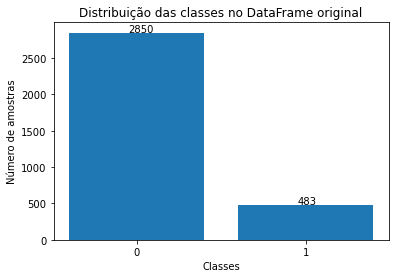

In [242]:
# Analisando a distribuição das classes
plot_balanceamento_classes(dados['churn'], 'Distribuição das classes no DataFrame original')

In [243]:
# Separando varáveis preditoras e alvo
variavel_alvo = dados.drop('churn', axis=1)
variaveis_preditoras = dados['churn']

In [244]:
# Aplicando balanceamento de classes
x_balanceado, y_balanceado = aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras)

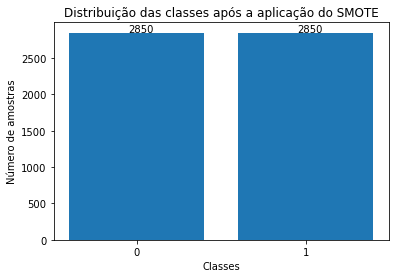

In [245]:
# Analisando a distribuição das classes após balanceamento
plot_balanceamento_classes(y_balanceado, 'Distribuição das classes após a aplicação do SMOTE')

In [246]:
x_balanceado.sample(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
609,50,111,1,0,0,0,146.200000,55,24.850000,261.500000,83,22.230000,163.200000,116,7.340000,8.700000,3,2.350000,3
548,6,31,1,0,1,31,100.100000,54,17.020000,246.300000,97,20.940000,255.000000,131,11.480000,5.900000,3,1.590000,0
3952,32,99,1,0,0,0,118.285165,74,20.110478,230.401705,93,19.582793,151.503253,108,6.821146,8.057358,3,2.176388,3
4179,21,92,0,0,0,0,130.397990,113,22.168227,254.214643,117,21.607820,245.796339,97,11.061907,8.954176,2,2.419196,2
4573,23,120,2,0,0,0,124.771533,109,21.211608,218.210755,99,18.550132,182.806799,124,8.228577,10.665894,2,2.882003,2


In [247]:
# Selecionando variáveis numéricas
lista_colunas_nao_numericas = ['international_plan', 'voice_mail_plan']

colunas_numericas = x_balanceado.drop(lista_colunas_nao_numericas, axis=1)
print('lista_colunas_numericas:', colunas_numericas.columns)

# Criando o StandardScaler para aplicar nas variáveis
scaler = StandardScaler()

lista_colunas_numericas: Index(['state', 'account_length', 'area_code', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')


In [248]:
# Analisando valores que serão normalizados.
t = x_balanceado[colunas_numericas.columns].head(5)

In [249]:
# Aplicando padronização
x_balanceado[colunas_numericas.columns] = scaler.fit_transform(colunas_numericas)

In [250]:
x_balanceado.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,-0.733724,0.695284,0.196478,0,1,1.481855,1.207020,0.465575,1.207258,-0.173696,-0.069783,-0.173503,0.886098,-0.479373,0.885313,-0.170259,-0.502398,-0.171012,-0.480499
1,0.663735,0.148144,0.196478,0,1,1.562749,-0.487908,1.133800,-0.488146,-0.211600,0.143752,-0.211056,1.088588,0.169082,1.089418,1.253414,-0.502398,1.254107,-0.480499
2,0.369533,0.929773,0.196478,0,0,-0.540501,0.851659,0.671183,0.851801,-1.693835,0.517439,-1.694385,-0.827769,0.223120,-0.826383,0.676249,0.350773,0.669808,-1.179363
3,0.663735,-0.451105,-1.261758,1,0,-0.540501,1.768721,-1.539100,1.768861,-2.876831,-0.657005,-2.877293,-0.111744,-0.587449,-0.112016,-1.478499,1.203944,-1.482121,0.218364
4,0.737285,-0.685594,0.196478,1,0,-0.540501,-0.404389,0.619781,-0.404340,-1.153208,1.158045,-1.152219,-0.320498,1.141764,-0.320760,-0.131782,-0.502398,-0.128258,0.917228


In [251]:
# Selecionando as melhores variáveis para o modelo
melhores_variaveis = selecionar_melhores_variaveis(x_balanceado, y_balanceado, 11)

# Exibindo as variáveis selecionadas
print("Variáveis selecionadas:", melhores_variaveis)

Variáveis selecionadas: Index(['area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_charge',
       'total_eve_minutes', 'total_eve_charge', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls'],
      dtype='object')


In [252]:
# Analisando dados atuais
x_balanceado.sample(10)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
4305,-0.145320,0.486850,-1.261758,0,1,1.643643,-0.332703,0.465575,-0.332376,-0.121211,1.158045,-0.120778,-0.799197,-0.263221,-0.797720,-0.092036,0.777358,-0.095638,1.616091
1408,0.443083,3.404933,-1.261758,0,0,-0.540501,-0.422403,0.157164,-0.422642,-0.203620,0.784358,-0.204015,-1.752547,-1.235903,-1.754131,0.522339,-0.502398,0.527296,-0.480499
105,-1.689880,-0.164508,-1.261758,0,0,-0.540501,0.764865,-1.847512,0.765104,-0.377179,-0.123167,-0.377696,-0.255784,0.817536,-0.255817,0.522339,-0.075812,0.527296,1.616091
2438,-0.954375,-0.242671,0.196478,0,0,-0.540501,0.095082,0.619781,0.094649,0.722029,0.837742,0.723066,-0.214034,-1.289941,-0.214069,0.214517,0.350773,0.213770,0.218364
1881,0.222432,-0.659540,0.196478,0,0,-0.540501,1.331479,-0.202650,1.331524,0.604328,-0.283318,0.603367,0.694044,0.277157,0.695125,-1.055245,-0.928983,-1.054586,-1.179363
5002,1.325689,0.304470,0.196478,0,0,-0.540501,1.283230,0.465575,1.283434,1.229682,0.997894,1.229109,0.223687,0.277157,0.223065,-0.673313,2.057114,-0.667447,-0.480499
5187,1.031487,0.278415,0.196478,1,0,-0.540501,0.016320,-1.179287,0.016134,-0.735817,-1.190843,-0.736177,-0.531050,-0.263221,-0.530399,1.192181,-0.928983,1.193456,0.218364
2412,1.619891,-0.320834,0.196478,0,0,-0.540501,2.209238,0.568379,2.209088,-0.818059,0.517439,-0.818939,-0.821506,-0.155146,-0.821744,-1.132201,-1.355569,-1.125841,-0.480499
4411,1.252139,-0.711648,0.196478,0,0,-0.540501,0.463578,-0.511061,0.463903,0.357559,-0.283318,0.357244,1.586372,-0.695525,1.587098,-0.185967,0.350773,-0.188615,-0.480499
2524,1.399239,0.122090,0.196478,0,0,-0.540501,0.717374,1.030996,0.716939,0.289129,-0.710389,0.288864,0.710745,-0.479373,0.709041,0.522339,-0.075812,0.527296,-0.480499


In [253]:
# Analisando dados somente com as variáveis selecionadas
x_balanceado = x_balanceado[melhores_variaveis]
x_balanceado.head(5)

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_intl_minutes,total_intl_calls,number_customer_service_calls
0,0.196478,0,1,1.481855,1.207020,1.207258,-0.173696,-0.173503,-0.170259,-0.502398,-0.480499
1,0.196478,0,1,1.562749,-0.487908,-0.488146,-0.211600,-0.211056,1.253414,-0.502398,-0.480499
2,0.196478,0,0,-0.540501,0.851659,0.851801,-1.693835,-1.694385,0.676249,0.350773,-1.179363
3,-1.261758,1,0,-0.540501,1.768721,1.768861,-2.876831,-2.877293,-1.478499,1.203944,0.218364
4,0.196478,1,0,-0.540501,-0.404389,-0.404340,-1.153208,-1.152219,-0.131782,-0.502398,0.917228


### Modelo de Regressão Logística

In [254]:
# Dividindo o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_balanceado, y_balanceado, test_size=0.3, random_state=42)

In [255]:
# Criando o modelo
model = LogisticRegression()

In [256]:
# Trinando o modelo
model.fit(x_treino, y_treino)

LogisticRegression()

In [257]:
# Fazendo previsões
y_pred = model.predict(x_teste)

In [258]:
# Avaliando o modelo
accuracy = accuracy_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
f1 = f1_score(y_teste, y_pred)
auc_roc = roc_auc_score(y_teste, y_pred)

In [259]:
print("Acurácia: {:.2f}%".format(accuracy * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))
print("AUC-ROC: {:.2f}%".format(auc_roc * 100))

Acurácia: 74.80%
Recall: 76.45%
F1-score: 74.60%
AUC-ROC: 74.85%
